In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

Imports

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from helpers import *
from scipy import ndimage
import random

In [3]:
# Loaded a set of images
# root_dir = "data/training/"
root_dir = "training/"

# image data
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

# image labels
gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


In [4]:
def get_rotated_images(images, angles):
    rotated_images = [None]*(len(imgs)*len(angles))
    i = 0
    for angle in angles:
        for image in images:
            rotated_images[i] = ndimage.rotate(image, angle, mode='reflect', order=0, reshape=False)
            i += 1
    return rotated_images

In [5]:
angles = random.sample(range(1, 360), 5)
rotated_imgs = get_rotated_images(imgs, angles)
gt_rotated_imgs = get_rotated_images(gt_imgs, angles)

In [6]:
imgs = imgs + rotated_imgs
gt_imgs = gt_imgs + gt_rotated_imgs

In [7]:
len(imgs)

600

Extract 16x16 patches from all training images and their corresponding label images

In [8]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels
n = len(imgs)

img_patches = [img_crop(imgs[i], patch_size, patch_size, step = 16) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size, step = 16) for i in range(n)]

print(len(img_patches))
print(len(img_patches[0]))
print(img_patches[0][0].shape)

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print(img_patches.shape)
print(img_patches[0].shape)

600
625
(16, 16, 3)
(375000, 16, 16, 3)
(16, 16, 3)


In [9]:
len(img_patches), len(gt_patches)

(375000, 375000)

Split data into training and validation sets

In [10]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    num_row=len(y)
    indices=np.random.permutation(num_row)
    index_split=int(np.floor(ratio*num_row))
    index_tr=indices[: index_split]
    index_te=indices[index_split :]
    
    x_tr=x[index_tr]
    y_tr=y[index_tr]
    x_te=x[index_te]
    y_te=y[index_te]
    return x_tr, y_tr, x_te, y_te


In [11]:
train_data, train_labels, eval_data, eval_labels = split_data(img_patches, gt_patches, 1, 63)

Assign label to each patch for training and validation sets

In [12]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return [0,1]
    else:
        return [1,0]

In [13]:
train_labels = np.asarray([value_to_class(np.mean(train_labels[i])) for i in range(len(train_labels))])

In [14]:
#train_labels = np.zeros((len(train_labels1), 2))
#train_labels[np.arange(len(train_labels1)), train_labels1] = 1

In [15]:
eval_labels = np.asarray([value_to_class(np.mean(eval_labels[i])) for i in range(len(eval_labels))])

In [16]:
len(eval_labels)

0

In [17]:
#eval_labels = np.zeros((len(eval_labels1), 2))
#eval_labels[np.arange(len(eval_labels1)), eval_labels1] = 1

Build CNN

In [18]:
x = tf.placeholder(tf.float32, [None, 16,16,3])
y_ = tf.placeholder(tf.float32, [None, 2])

In [19]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [20]:
def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

In [21]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides =[1, 1, 1, 1], padding = 'SAME')

In [22]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding ='SAME')

In [23]:
W_conv1 = weight_variable([5,5,3,32])
b_conv1 = bias_variable([32])

In [24]:
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)

In [25]:
h_pool1 = max_pool_2x2(h_conv1)

In [26]:
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

In [27]:
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

In [28]:
h_pool2 = max_pool_2x2(h_conv2)

In [29]:
print(h_pool2.get_shape())

(?, 4, 4, 64)


In [30]:
W_fcl = weight_variable([4*4*64, 1024])
b_fcl = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 4*4*64])

h_fcl = tf.nn.relu(tf.matmul(h_pool2_flat, W_fcl) + b_fcl)

In [31]:
print(h_fcl.get_shape())


(?, 1024)


In [32]:
keep_prob = tf.placeholder('float')
h_fcl_drop = tf.nn.dropout(h_fcl, keep_prob)

In [33]:
W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

y = tf.nn.softmax(tf.matmul(h_fcl_drop, W_fc2)+b_fc2)

In [34]:
print(y.get_shape())


(?, 2)


In [35]:
LEARNING_RATE = 1e-4

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [36]:
predict = tf.argmax(y,1)

Define function to go over batches of images

In [37]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_data.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_data
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # reorder randomly when all training data covered
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_data = train_data[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_data[start:end], train_labels[start:end]

Init CNN

In [38]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

In [39]:
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 2500        
DROPOUT = 0.5
VALIDATION_SIZE = 0
BATCH_SIZE= 100

In [40]:
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    # get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)  
    
    # display accuracy for training and validation
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: eval_data[0:BATCH_SIZE], 
                                                            y_: eval_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy => 0.5200 for step 0
training_accuracy => 0.6400 for step 1
training_accuracy => 0.7500 for step 2
training_accuracy => 0.7000 for step 3
training_accuracy => 0.7700 for step 4
training_accuracy => 0.7600 for step 5
training_accuracy => 0.7800 for step 6
training_accuracy => 0.7200 for step 7
training_accuracy => 0.7200 for step 8
training_accuracy => 0.7500 for step 9
training_accuracy => 0.7500 for step 10
training_accuracy => 0.8500 for step 20
training_accuracy => 0.7900 for step 30
training_accuracy => 0.7800 for step 40
training_accuracy => 0.7000 for step 50
training_accuracy => 0.7100 for step 60
training_accuracy => 0.7400 for step 70
training_accuracy => 0.6900 for step 80
training_accuracy => 0.7800 for step 90
training_accuracy => 0.8000 for step 100
training_accuracy => 0.7300 for step 200
training_accuracy => 0.6600 for step 300
training_accuracy => 0.7400 for step 400
training_accuracy => 0.7900 for step 500
training_accuracy => 0.7500 for step 600
trai

In [41]:
# Data to evaluate
# root_testdir = "data/test_set_images"
root_testdir = "test_set_images"
test_names = os.listdir(root_testdir)

prefixes = ('.')
for dir_ in test_names[:]:
    if dir_.startswith(prefixes):
        test_names.remove(dir_)
        
num_test = len(test_names)

####### Chope la permutation pour avir les data dans l'ordre
order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
p = np.argsort(order)

imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") for i in range(num_test)]
####### Remet les data dans l'ordre
imgs_test = [imgs_test[i] for i in p]

img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size, step = 16) for i in range(num_test)]
# Linearize list of patches
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

In [42]:
img_patches_test.shape

(72200, 16, 16, 3)

In [44]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 50)

pred_list = []

# Evaluation de la prédiction par morceau pouréviter l'overflow et de faire crasher le programme
for i, [_, test_index] in enumerate(kf.split(img_patches_test)):
    print("Fold ", i, " -- TEST:", test_index)
    X_test = img_patches_test[test_index]
    
    feed_dict = {x: X_test, keep_prob: 1.0}
    pred = predict.eval(feed_dict)
    
    pred_list.append(pred) 

# REconstruction du vecteur des prédictions
predictions = pred_list[0]
for i in range(1, len(pred_list)):
    predictions = np.concatenate([predictions, pred_list[i]], axis = 0)

Fold  0  -- TEST: [   0    1    2 ..., 1441 1442 1443]
Fold  1  -- TEST: [1444 1445 1446 ..., 2885 2886 2887]
Fold  2  -- TEST: [2888 2889 2890 ..., 4329 4330 4331]
Fold  3  -- TEST: [4332 4333 4334 ..., 5773 5774 5775]
Fold  4  -- TEST: [5776 5777 5778 ..., 7217 7218 7219]
Fold  5  -- TEST: [7220 7221 7222 ..., 8661 8662 8663]
Fold  6  -- TEST: [ 8664  8665  8666 ..., 10105 10106 10107]
Fold  7  -- TEST: [10108 10109 10110 ..., 11549 11550 11551]
Fold  8  -- TEST: [11552 11553 11554 ..., 12993 12994 12995]
Fold  9  -- TEST: [12996 12997 12998 ..., 14437 14438 14439]
Fold  10  -- TEST: [14440 14441 14442 ..., 15881 15882 15883]
Fold  11  -- TEST: [15884 15885 15886 ..., 17325 17326 17327]
Fold  12  -- TEST: [17328 17329 17330 ..., 18769 18770 18771]
Fold  13  -- TEST: [18772 18773 18774 ..., 20213 20214 20215]
Fold  14  -- TEST: [20216 20217 20218 ..., 21657 21658 21659]
Fold  15  -- TEST: [21660 21661 21662 ..., 23101 23102 23103]
Fold  16  -- TEST: [23104 23105 23106 ..., 24545 24546

In [49]:
# feed_dict = {x: img_patches_test, keep_prob: 1.0}
# predictions = predict.eval(feed_dict)

In [58]:
predictions.shape

(72200,)

In [52]:
def create_submission(y_pred, submission_filename, patch_size = 16, images_size = 608):
    n_patches = images_size // patch_size
    y_pred = np.reshape(y_pred, (-1, n_patches, n_patches))
    
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(y_pred.shape[0]):
            for j in range(y_pred.shape[1]):
                for k in range(y_pred.shape[2]):
                    name = '{:03d}_{}_{},{}'.format(i+1, j * patch_size, k * patch_size, int(y_pred[i,j,k]))
                    f.write(name + '\n')

In [53]:
create_submission(predictions, "submission_math.csv")

In [54]:
imgs_test[0].shape

(608, 608, 3)

In [59]:
i = 45

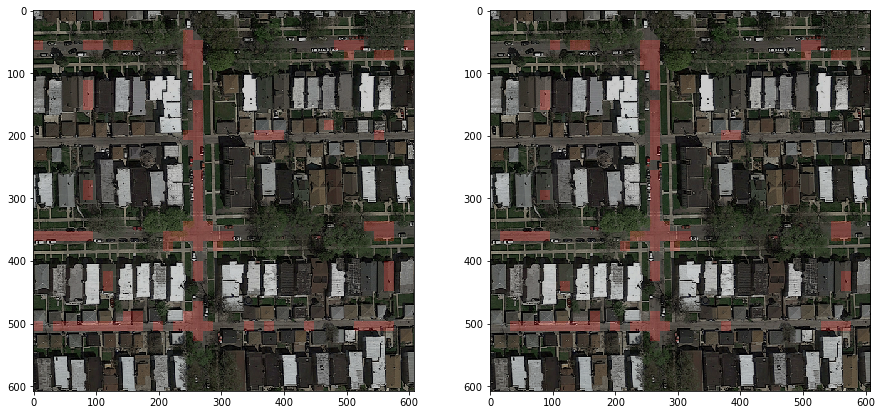

In [60]:
feed_dict = {x: img_patches_test[(i)*38*38:(i+1)*38*38], keep_prob: 1.0}
Zi = y.eval(feed_dict)
Zi = Zi.argmax(axis=1)
img_idx = i
patch_size = 16

# Display prediction as an image
w = imgs_test[img_idx].shape[0]
h = imgs_test[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
#cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(15, 15)) # create a figure with the default size 
#plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs_test[img_idx], predicted_im)

plt.subplot(121)

plt.imshow(new_img)


Zi_reshaped = np.reshape(Zi, [608 // 16, 608 // 16])
postprocess_img = postprocess(Zi_reshaped)
postprocess_img = np.reshape(postprocess_img, [Zi.shape[0]])
postprocess_img = label_to_img(w, h, patch_size, patch_size, postprocess_img)
    
plt.subplot(122)
#fig1 = plt.figure(figsize=(10, 10)) 
new_img = make_img_overlay(imgs_test[img_idx], postprocess_img)
plt.imshow(new_img)

In [158]:
i = 96

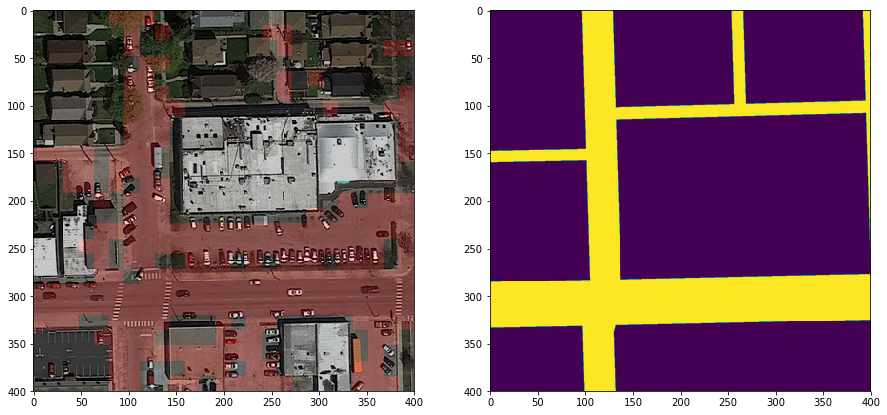

In [159]:
#feed_dict = {x: eval_data[:i*400*400], keep_prob: 1.0}
#Zi = y.eval(feed_dict)
#Zi = Zi.argmax(axis=1)
Zi = sess.run(tf.argmax(y, 1), feed_dict={x: eval_data[:i*400*400], keep_prob: 1.0})


img_idx = i
patch_size = 16

# Display prediction as an image
w = imgs[img_idx].shape[0]
h = imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
#cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(15, 15)) # create a figure with the default size 
#plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.subplot(121)

plt.imshow(new_img)

plt.subplot(122)

plt.imshow(gt_imgs[img_idx])